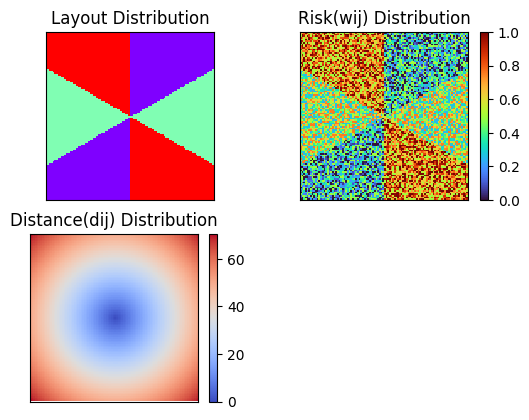

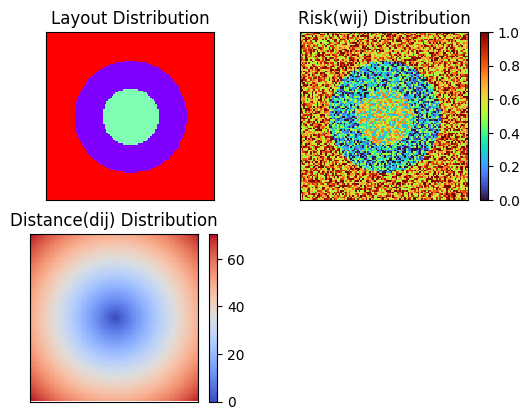

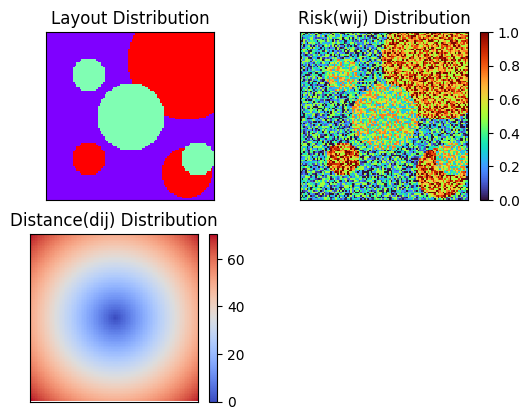

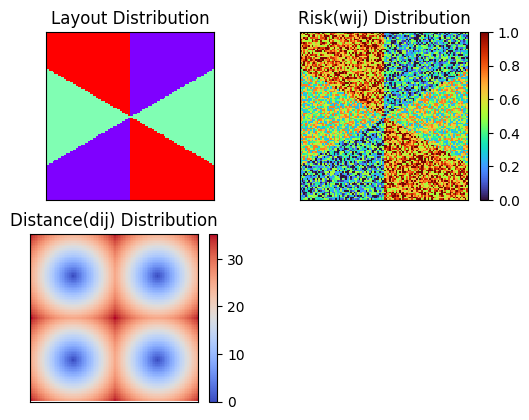

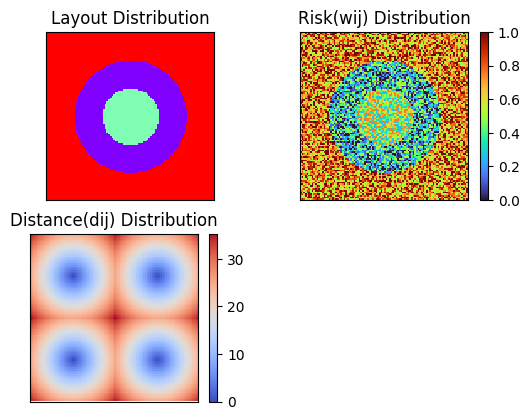

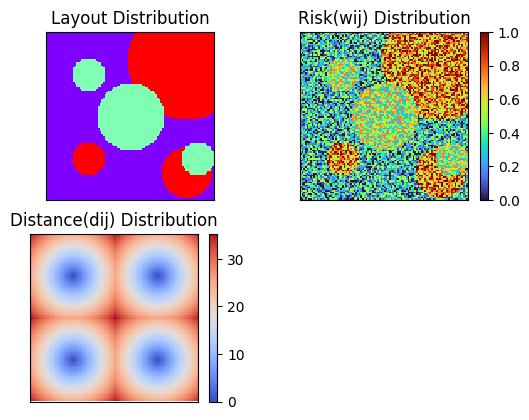

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import pairwise_distances_argmin_min
import Building

np.random.seed(8888)


def getDistance(vec1, vec2):
    return np.linalg.norm(vec1 - vec2)


class City:

    ConcentricCircle = 0
    Sector = 1
    MultipleNucleus = 2

    CentralizedFF = 0
    DispersedFF = 1

    def __init__(self, layoutType, ffType=CentralizedFF, citySize=100):
        self.citySize = citySize
        self.layoutType = layoutType
        self.layout = []
        self.buildLayout()
        self.ffType = ffType
        self.fireStations = []
        self.buildFireStations()

    def buildLayout(self):
        if self.layoutType == City.ConcentricCircle:
            self.buildConcentricCircleLayout()
        elif self.layoutType == City.Sector:
            self.buildSectorLayout()
        elif self.layoutType == City.MultipleNucleus:
            self.buildMultiNucleusLayout()
        else:
            self.buildConcentricCircleLayout()

    def buildConcentricCircleLayout(self):
        halfSize = self.citySize / 2
        center = np.asarray([self.citySize / 2, self.citySize / 2])
        for i in range(self.citySize):
            self.layout.append([])
            for j in range(self.citySize):
                point = np.asarray([i, j])
                dis = getDistance(point, center)
                if dis < halfSize / 3:
                    self.layout[i].append(Building.CommercialBuilding(i, j))
                elif halfSize / 3 <= dis < halfSize * 2 / 3:
                    self.layout[i].append(Building.ResidentialBuilding(i, j))
                else:
                    self.layout[i].append(Building.IndustrialBuilding(i, j))

    def buildSectorLayout(self):
        halfSize = self.citySize / 2
        axisX = np.asarray([1, 0])
        for i in range(self.citySize):
            self.layout.append([])
            for j in range(self.citySize):
                vec = np.asarray([i, j]) - np.asarray([halfSize, halfSize])
                cos = vec.dot(axisX) / max(np.linalg.norm(vec), 0.1)
                angle = np.arccos(cos)*180/np.pi
                if (0 <= angle < 60 and j < halfSize) or (120 <= angle <= 180 and j >= halfSize):
                    self.layout[i].append(Building.ResidentialBuilding(i, j))
                elif 60 <= angle < 120:
                    self.layout[i].append(Building.CommercialBuilding(i, j))
                elif (0 <= angle < 60 and j >= halfSize) or (120 <= angle <= 180 and j < halfSize):
                    self.layout[i].append(Building.IndustrialBuilding(i, j))
                else:
                    self.layout[i].append(Building.Building(i, j))

    def buildMultiNucleusLayout(self):
        halfSize = self.citySize / 2
        commercialCenter = np.asarray([[halfSize/2, halfSize/2],
                                       [halfSize, halfSize],
                                       [self.citySize - halfSize / 2, self.citySize - halfSize / 5]])
        industrialCenter = np.asarray([[self.citySize - halfSize / 2, halfSize / 2],
                                       [halfSize / 3, self.citySize - halfSize / 3],
                                       [self.citySize - halfSize / 3, self.citySize - halfSize / 3]])
        for i in range(self.citySize):
            self.layout.append([])
            for j in range(self.citySize):
                point = np.asarray([i, j])
                if getDistance(point, commercialCenter[0]) < 10 \
                        or getDistance(point, commercialCenter[1]) < 20 \
                        or getDistance(point, commercialCenter[2]) < 10:
                    self.layout[i].append(Building.CommercialBuilding(i, j))
                elif getDistance(point, industrialCenter[0]) < 10 \
                        or getDistance(point, industrialCenter[1]) < 35 \
                        or getDistance(point, industrialCenter[2]) < 15:
                    self.layout[i].append(Building.IndustrialBuilding(i, j))
                else:
                    self.layout[i].append(Building.ResidentialBuilding(i, j))

    def getW(self):
        wShot = np.zeros([self.citySize, self.citySize])
        for i in range(self.citySize):
            for j in range(self.citySize):
                wShot[i][j] = self.layout[i][j].w
        return wShot

    def getD(self):
        dShot = np.zeros([self.citySize, self.citySize])
        for i in range(self.citySize):
            for j in range(self.citySize):
                dShot[i][j] = self.layout[i][j].d
        return dShot

    def getT(self):
        tShot = np.zeros([self.citySize, self.citySize])
        for i in range(self.citySize):
            for j in range(self.citySize):
                tShot[i][j] = self.layout[i][j].t
        return tShot

    def show(self):
        plt.figure()
        plt.subplot(2, 2, 1)
        self.drawT()
        plt.subplot(2, 2, 2)
        self.drawW()
        plt.subplot(2, 2, 3)
        self.drawD()
        plt.show()

    def drawW(self):
        wShot = self.getW()
        plt.imshow(wShot, cmap='turbo', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        plt.title('Risk(wij) Distribution')

    def drawD(self):
        dShot = self.getD()
        plt.imshow(dShot, cmap='coolwarm', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        plt.colorbar()
        plt.title('Distance(dij) Distribution')

    def drawT(self):
        tShot = self.getT()
        plt.imshow(tShot, cmap='rainbow', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])
        # plt.colorbar()
        plt.title('Layout Distribution')

    def buildFireStations(self):
        halfSize = self.citySize/2
        if self.ffType == City.CentralizedFF:
            self.fireStations.append([halfSize, halfSize])
        else:
            self.fireStations.append([halfSize / 2, halfSize / 2])
            self.fireStations.append([self.citySize - halfSize / 2, halfSize / 2])
            self.fireStations.append([halfSize / 2, self.citySize - halfSize / 2])
            self.fireStations.append([self.citySize - halfSize / 2, self.citySize - halfSize / 2])
        self.update()

    def update(self):
        buildings = []
        for row in self.layout:
            for building in row:
                buildings.append([building.x, building.y])

        nearestIndexList, nearestDisList = pairwise_distances_argmin_min(buildings, self.fireStations)
        for i in range(len(nearestIndexList)):
            x = buildings[i][0]
            y = buildings[i][1]
            self.layout[x][y].setDistance(nearestDisList[i])


if __name__ == "__main__":
    city1 = City(City.Sector)
    city1.show()

    city2 = City(City.ConcentricCircle)
    city2.show()

    city3 = City(City.MultipleNucleus)
    city3.show()

    city4 = City(City.Sector, City.DispersedFF)
    city4.show()

    city5 = City(City.ConcentricCircle, City.DispersedFF)
    city5.show()

    city6 = City(City.MultipleNucleus, City.DispersedFF)
    city6.show()

In [3]:
#Get w_ij, and d_ij for different city

w_ij = city2.getW()  # np.array
d_ij = city2.getD()  # np.array

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import expit as sigmoid

In [7]:
# Constants for the problem
alpha = 0.5
beta = 0.5
gamma = 1.0
Budget = 800000  # Example budget
cityNumber = 1

# Gradient descent approach

Iteration 0: Current cost = 688426.3376007241, Objective value = 4250.076103280719
Iteration 100: Current cost = 711730.9070990765, Objective value = 4248.813551462075
Iteration 200: Current cost = 736662.9567638646, Objective value = 4247.461747129056
Iteration 300: Current cost = 763399.418531707, Objective value = 4246.010873716182
Iteration 400: Current cost = 792143.9153677373, Objective value = 4244.4496169483555
Budget exceeded at iteration 427: Current cost = 800278.915813455
Final objective function value: 4244.007499549579


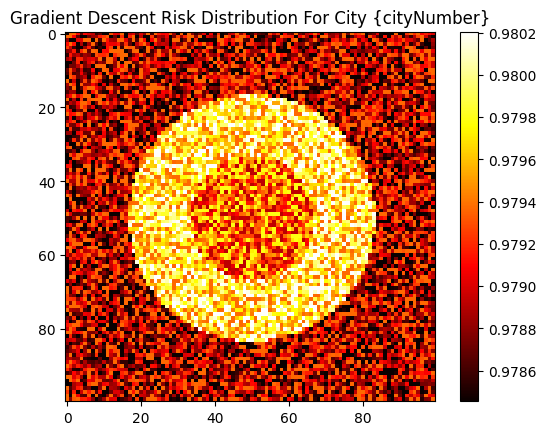

In [11]:
# Objective function
def objective_function(e_ij):
    f_ij = sigmoid(e_ij)
    return np.sum(w_ij * f_ij + alpha * (f_ij)**2 - beta * np.log(1 + gamma * f_ij))

# Scaled cost function to include the random distances
def scaled_c(f_ij, d_ij):
    return 100 * d_ij * (1 - f_ij)

# Gradient of the objective function with respect to e_ij
def gradient(e_ij):
    f_ij = sigmoid(e_ij)
    df_dc = sigmoid_derivative(e_ij)
    grad_risk_term = (w_ij + 2 * alpha * f_ij) * df_dc
    grad_log_term = -beta * (gamma * df_dc) / (1 + gamma * f_ij)
    return grad_risk_term - grad_log_term

# Derivative of the sigmoid function
def sigmoid_derivative(e_ij):
    return sigmoid(e_ij) * (1 - sigmoid(e_ij))

# Gradient descent parameters
learning_rate = 0.01
iterations = 10000

# Initialize e_ij with all ones
e_ij = np.full((100, 100), 4.0)

# Perform gradient descent optimization
for i in range(iterations):
    grad = gradient(e_ij) 
    e_ij -= learning_rate * grad
    f_ij = sigmoid(e_ij)
    current_cost = np.sum(scaled_c(f_ij, d_ij))
    current_objective_value = objective_function(f_ij)
    
    if current_cost > Budget:
        print(f"Budget exceeded at iteration {i}: Current cost = {current_cost}")
        break

    if i % 100 == 0:
        print(f"Iteration {i}: Current cost = {current_cost}, Objective value = {current_objective_value}")

# Final objective function value
final_objective_value = objective_function(sigmoid(e_ij))
print(f"Final objective function value: {final_objective_value}")

# Plotting the final risk distribution
final_f_ij = sigmoid(e_ij)
plt.imshow(final_f_ij, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f"Gradient Descent Risk Distribution For City {cityNumber}")
plt.show()

# Baseline approach: start with e_ij = 1 for all e_ij and decrease equally until the budget is reached

Baseline Final objective function value: 7216.790881743328


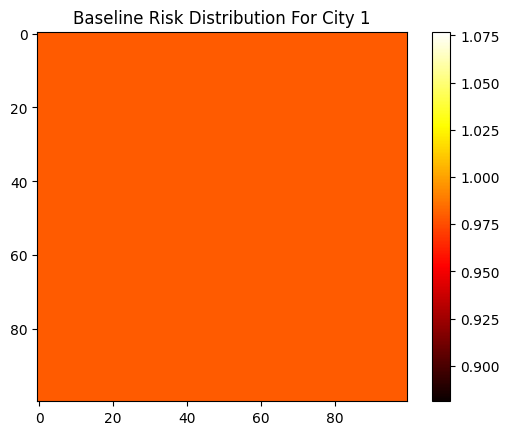

In [10]:


# Initialize e_ij with all ones
e_ij_baseline = np.full((100, 100), 10.0)

# Find the step to decrease e_ij to stay within the budget
budget_reached = False
decrement_step = 0.001

while not budget_reached:
    f_ij_baseline = sigmoid(e_ij_baseline)
    current_cost = np.sum(scaled_c(f_ij_baseline, d_ij))
    if current_cost >= Budget:
        budget_reached = True
    else:
        # Equally decrease all e_ij
        e_ij_baseline -= decrement_step

# Calculate the final objective value for the baseline approach
final_objective_value_baseline = objective_function(e_ij_baseline)
print(f"Baseline Final objective function value: {final_objective_value_baseline}")

# Plotting the final risk distribution for the baseline approach
final_f_ij_baseline = sigmoid(e_ij_baseline)
plt.imshow(final_f_ij_baseline, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f"Baseline Risk Distribution For City {cityNumber}")
plt.show()

# CvxPy approach

In [12]:
import numpy as np
import cvxpy as cp


# Risk levels f_ij are the variables we want to solve for, initialized here
f_ij = cp.Variable((100, 100))

# The objective function components
risk = cp.sum(cp.multiply(w_ij, f_ij))
quadratic_risk = cp.sum(alpha * cp.square(f_ij))
logarithmic_term = beta * cp.sum(cp.log(1 + gamma * f_ij))

# Total objective function
objective = cp.Minimize(risk + quadratic_risk - logarithmic_term)

# Constraint functions
cost_function = cp.sum(cp.multiply(100 * d_ij, (1 - f_ij)))
constraints = [cost_function <= Budget, f_ij >= 0, f_ij <= 1]

# Problem definition
problem = cp.Problem(objective, constraints)

# Solve the problem
problem.solve()

# Check if the problem was solved
if problem.status not in ["infeasible", "unbounded"]:
    # Problem has an optimal solution
    print(f"Optimal risk value: {problem.value}")
    # Display the optimal f_ij values
    optimal_f_ij = f_ij.value
else:
    print("Problem has no optimal solution.")

C:\Users\felix\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\cvxpy\reductions\solvers\solving_chain.py:336: FutureWarning: 
    Your problem is being solved with the ECOS solver by default. Starting in 
    CVXPY 1.5.0, Clarabel will be used as the default solver instead. To continue 
    using ECOS, specify the ECOS solver explicitly using the ``solver=cp.ECOS`` 
    argument to the ``problem.solve`` method.
    
  warnings.warn(ECOS_DEPRECATION_MSG, FutureWarning)


Optimal risk value: 6879.950917095416


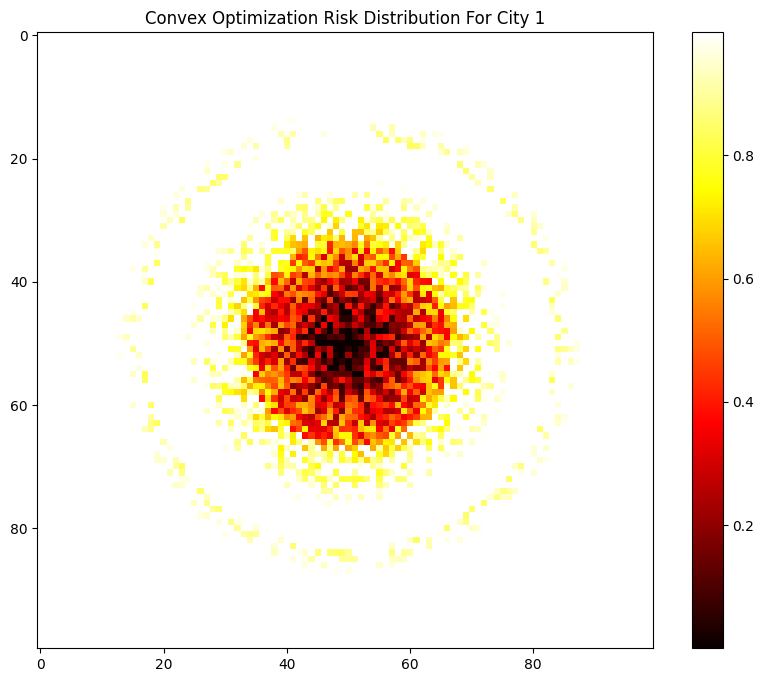

In [13]:
plt.figure(figsize=(10, 8))
plt.imshow(optimal_f_ij, cmap='hot', interpolation='nearest')
plt.colorbar()
plt.title(f"Convex Optimization Risk Distribution For City {cityNumber}")
plt.show()